### Rationale

There is not current consensus on durations of prescription within the NHS and prescribers are advised that they should write a prescription for a duration that is clinically approprite. For medicines that are for stable long-term conditions many areas have polices in place recommending one, two, or three motnh prescritpions.

The [British Medical Association reports](https://www.bma.org.uk/advice/employment/gp-practices/service-provision/prescribing/prescribing-in-general-practice) growing requests to prescribe seven day quantities of medicines to fund supply of medicine compliance aids (MCAs). MCAs, sometimes known as dosette boxes or pill organisers, are plastic boxes with small compartments that clearly show which pills need to be taken at what time of day. The Royal Pharmaceutical Society has issued [guidance](https://www.rpharms.com/Portals/0/RPS%20document%20library/Open%20access/Support/toolkit/rps-mca-july-2013.pdf) stating that while some may think of MCAs as a pancea, there is limited eveidence base to support their use, the use of original packs of medicines with appropriate support is the preferred option of
supplying medicines and every patient identified as having medicines adherence issues should have a robust
individual assessment to identify the best intervention based on their needs and the evidence
currently available.

A recent Pharmaceutical Journal [article](https://www.pharmaceutical-journal.com/news-and-analysis/features/are-we-dispensing-too-many-multicompartment-compliance-aids/20206131.article) that questions the amount of MCAs currently in use as well as highlighting grwoing safety concerns supported by data from the National Reporting and Learning System and the National Pharmacy Association. The article conatins an estimate of 64million MCAs used annually in England, in this measure we propose a measure of seven day prescriptions for long-term conditions as a surrogate measure for MCAs. Caveats include; a seven day prescription may be clinically relevant even for long-term conditions in certain circumstances, some pharmacies will supply a MCA without a seven day prescritpion after making an individual assessement and some local areas may fund provision of MCAs via a seperate payment.

**Proposed Measure**

**Title** Seven Day Prescribing for Long Term Conditions

**Description** Total quantity where a prescritpion is for seven tablets or capsules of common LTC medicines as a proportion of all tablets or capsules for common LTC medicines

**Why it matters**  
The [British Medical Association reports](https://www.bma.org.uk/advice/employment/gp-practices/service-provision/prescribing/prescribing-in-general-practice) growing requests to prescribe seven day quantities of medicines to fund supply of medicine compliance aids (MCAs). As well as increasing safety concerns, The Royal Pharmaceutical Society has issued [guidance](https://www.rpharms.com/Portals/0/RPS%20document%20library/Open%20access/Support/toolkit/rps-mca-july-2013.pdf) stating that while some may think of MCAs as a pancea, there is limited eveidence base to support their use, the use of original packs of medicines with appropriate support is the preferred option of
supplying medicines and every patient identified as having medicines adherence issues should have a robust
individual assessment to identify the best intervention based on their needs and the evidence
currently available. We propose a measure of seven day prescriptions for long-term conditions as a surrogate measure for MCAs. Caveats include; a seven day prescription may be clinically relevant even for long-term conditions in certain circumstances, some pharmacies will supply a MCA without a seven day prescritpion after making an individual assessement and some local areas may fund provision of MCAs via a seperate payment.  Please note that this is an experimental measure. We would be grateful for any feedback at [feedback@openprescribing.net](mailto:feedback@openprescribing.net) You can read more detail on the measure definition/notebook [here](insert Github/notebook def)

In [1]:
##importing libraries that are need to support analysis
import pandas as pd
import numpy as np
from ebmdatalab import bq, maps, charts
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#### Numerator & Denominator

In order to identify common long term medicines we will look for the the top most dispensed capsules and tablets from chapters 1, 2, 4, and 6 of the [BNF coding system](https://ebmdatalab.net/prescribing-data-bnf-codes/) where a lot of medicines for LTC reside. We will then select the five most common in 2019 for our _basket_ of medicines for long-term conditions

In [2]:
sql='''
SELECT
extract(year from month) AS year,
bnf.chemical,
SUM(items) AS total_items,
SUM(total_quantity) AS total_tabs_caps
FROM
  ebmdatalab.hscic.raw_prescribing_normalised AS presc
INNER JOIN
  hscic.bnf as bnf
ON
  presc.bnf_code=bnf.presentation_code

WHERE
(presentation LIKE '%_Tab%' or presentation LIKE '%_Cap%')
    AND SUBSTR(bnf_code,0,2) IN ('01','02','04','06') ## here we use common BNF chapters. Chapter 3 resp is excluded due to amount of inhalers
GROUP BY
bnf.chemical,
year
ORDER BY
total_items
'''


df_total_meds = bq.cached_read(sql, csv_path='total_meds.csv')


In [3]:
##here we restrict to 2019
df_2019 = df_total_meds.loc[(df_total_meds["year"] == 2019)].sort_values("total_tabs_caps", ascending=False)
df_2019.head(12)

,year,chemical,total_items,total_tabs_caps
1538,2019,Paracetamol,9531703,1206085847
1546,2019,Metformin Hydrochloride,12791762,1129666634
1531,2019,Co-Codamol (Codeine Phos/Paracetamol),8717935,998726264
1574,2019,Atorvastatin,25910424,837724311
1562,2019,Omeprazole,18122855,693453295
1564,2019,Levothyroxine Sodium,18863534,689705992
1561,2019,Amlodipine,17471969,600152475
1559,2019,Ramipril,16822703,585927190
1557,2019,Lansoprazole,15186321,497041216
1553,2019,Bisoprolol Fumarate,14203846,442396986


From this list we will select Atorvastatin, Simvastatin, Levothryroxine, Amlodipine and Ramipril as 5 common medicines used in LTC in a once daily manner. Paracetamol, co-codamol are excluded as can be used when required and for short term illnesses. Metformin, Lansoprazole, omeprazole, bisoprolol and Gabapentin are excluded due to them being given twice or three times a day in certain circumstances.

In [4]:
### here we extract data for modelling
sql = '''
SELECT
  CAST(month AS DATE) AS month,
  pct,
  SUM(CASE
      WHEN quantity_per_item=7 THEN total_quantity
      ELSE 0
  END) AS seven_day,
  SUM(total_quantity) AS all_QI,
  IEEE_DIVIDE(SUM(CASE
      WHEN quantity_per_item=7 THEN total_quantity
      ELSE 0
  END),
      SUM(total_quantity)) AS percent_7_day
FROM
 ebmdatalab.hscic.raw_prescribing_normalised AS presc
JOIN
  hscic.ccgs AS ccgs
ON
presc.pct=ccgs.code

WHERE
(bnf_code LIKE "0205051R0%" OR  ##ramipril
bnf_code LIKE "0212000B0%" OR ##atrovastatin
bnf_code LIKE "0212000Y0%" OR ##simvastatin
bnf_code LIKE "0602010V0%" OR ##levothyroxine
bnf_code LIKE "0206020A0%") ##amlodipine
AND
(bnf_name LIKE '%_Tab%' or bnf_name LIKE '%_Cap%') ##this restricts to tablets or capsules
AND
ccgs.org_type='CCG'
GROUP BY
  month,
  pct
ORDER BY
  percent_7_day DESC
    '''

df_mca = bq.cached_read(sql, csv_path='mca_askets.csv')
df_mca['month'] = df_mca['month'].astype('datetime64[ns]')
df_mca.head()

,month,pct,seven_day,all_QI,percent_7_day
0,2018-10-01,08V,326641,1822150,0.179261
1,2017-06-01,08V,287175,1628342,0.176360
2,2019-02-01,08V,284613,1617496,0.175959
3,2017-12-01,08V,280469,1618338,0.173307
4,2018-09-01,08V,277795,1605932,0.172981


C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


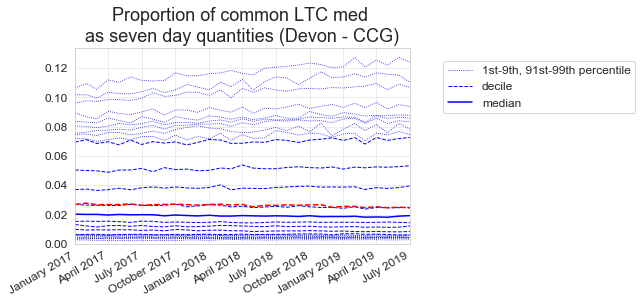

In [5]:
#create sample deciles

charts.deciles_chart(
        df_mca,
        period_column='month',
        column='percent_7_day',
        title="Proportion of common LTC med \n as seven day quantities (Devon - CCG) ",
        show_outer_percentiles=True)

#add in example CCG (Devon - 15N)
df_subject = df_mca.loc[df_mca['pct'] == '15N'].sort_values(by=['month'])
plt.plot(df_subject['month'], df_subject['percent_7_day'], 'r--')

plt.show()

In [6]:
##Restrict to latest month (July-2019) to create a map
latest_df_mca = df_mca.loc[(df_mca['month'] == '2019-07-01')]

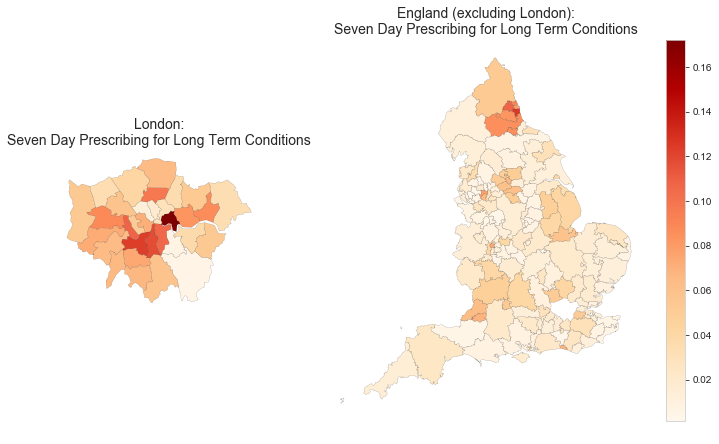

In [7]:
#create choropeth map 
plt.figure(figsize=(12, 7))
plt = maps.ccg_map(latest_df_mca, title="Seven Day Prescribing for Long Term Conditions", column='percent_7_day', separate_london=True)
plt.show()